In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import asyncio
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

from arch import arch_model
from sklearn.linear_model import LinearRegression

In [40]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.utils.dates import duration_to_dates
from proj.features import transforms

In [5]:
plt.style.use("styler.mplstyle") 

In [6]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 11, 17), datetime.date(2025, 11, 17))

## Feature Selection

In [7]:
macro = [
    'CPIAUCSL',   # CPI (All Urban Consumers)
    'INDPRO',     # Industrial Production Index
    'CNP16OV',    # Civilian Noninstitutional Population, 16+
    'FEDFUNDS',   # Effective Federal Funds Rate
    'VIXCLS',     # CBOE VIX Index (correct FRED ticker)
    'UNRATE'      # Unemployment Rate
]

In [8]:

macro_series = load_macro_series(macro, START_DATE, END_DATE)

In [9]:
macro_series

,DATE,CPIAUCSL,INDPRO,CNP16OV,FEDFUNDS,VIXCLS,UNRATE
0,2015-11-17,NaN,NaN,NaN,NaN,18.84,NaN
1,2015-11-18,NaN,NaN,NaN,NaN,16.85,NaN
2,2015-11-19,NaN,NaN,NaN,NaN,16.99,NaN
3,2015-11-20,NaN,NaN,NaN,NaN,15.47,NaN
4,2015-11-23,NaN,NaN,NaN,NaN,15.62,NaN
...,...,...,...,...,...,...,...
2636,2025-11-10,324.368,103.9203,274001.0,4.09,17.60,4.3
2637,2025-11-11,324.368,103.9203,274001.0,4.09,17.28,4.3
2638,2025-11-12,324.368,103.9203,274001.0,4.09,17.51,4.3
2639,2025-11-13,324.368,103.9203,274001.0,4.09,20.00,4.3


In [16]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [48]:
stock_series = await load_ibkr_prices(stock_data, DURATION)

Connected to Interactive Brokers successfully.


In [49]:
stock_series

,date,SPY,XLE
0,2015-11-23,209.07,67.38
1,2015-11-24,209.35,68.82
2,2015-11-25,209.32,68.26
3,2015-11-27,209.56,67.77
4,2015-11-30,208.69,68.02
...,...,...,...
2506,2025-11-11,683.00,91.53
2507,2025-11-12,683.38,90.25
2508,2025-11-13,672.04,90.48
2509,2025-11-14,671.93,92.02


In [50]:
stock_series['XLE_r'] = transforms.log_returns(stock_series, 'XLE')
stock_series['SPY_r'] = transforms.log_returns(stock_series, 'SPY')

In [51]:
df = stock_series.merge(macro_series, left_on='date', right_on=['DATE']).drop(columns=['date'])

In [52]:
df.dropna(inplace=True)

#### Macro Features

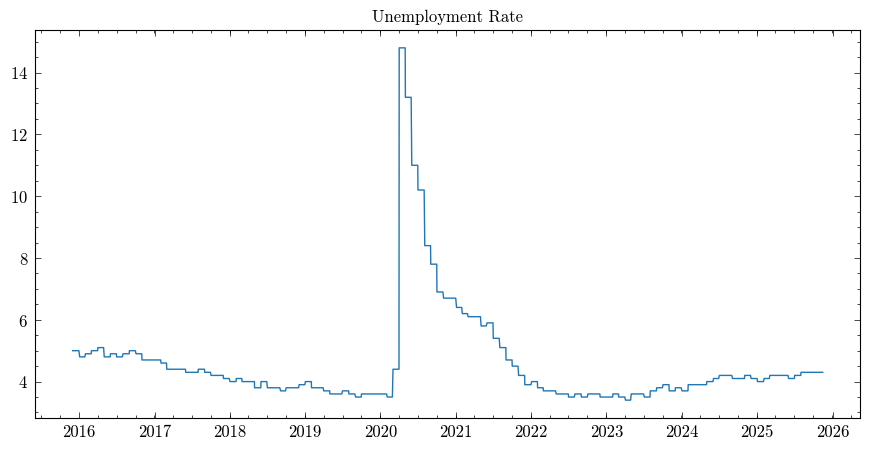

In [53]:
plt.figure(figsize=(10,5))
plt.title("Unemployment Rate")
plt.plot(df['DATE'], df['UNRATE'])

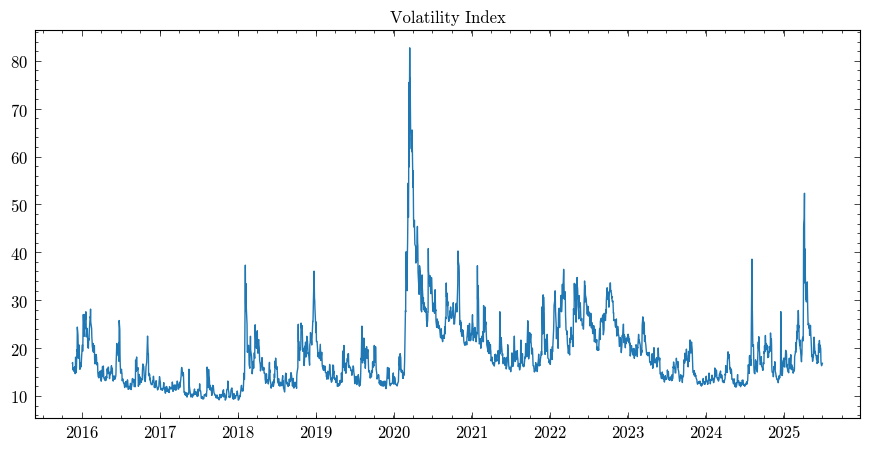

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Volatility Index")
plt.plot(df['DATE'], df['VIXCLS'])

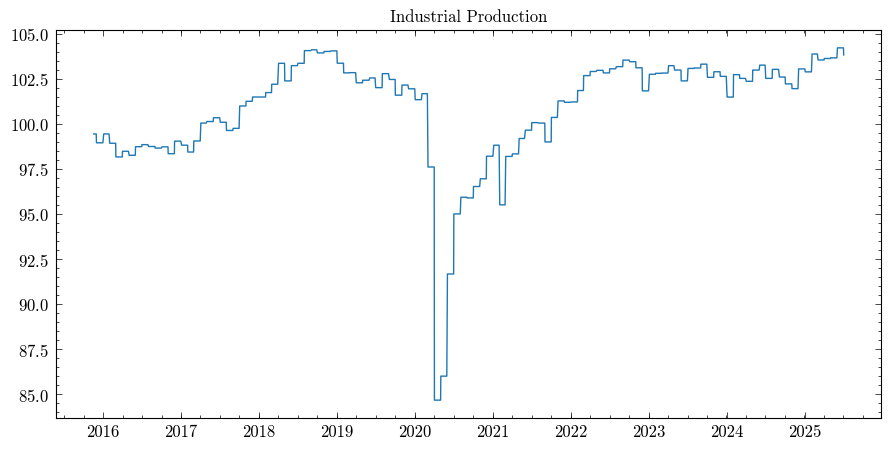

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Industrial Production")
plt.plot(df['DATE'], df['INDPRO'])

#### Stock and Indicators

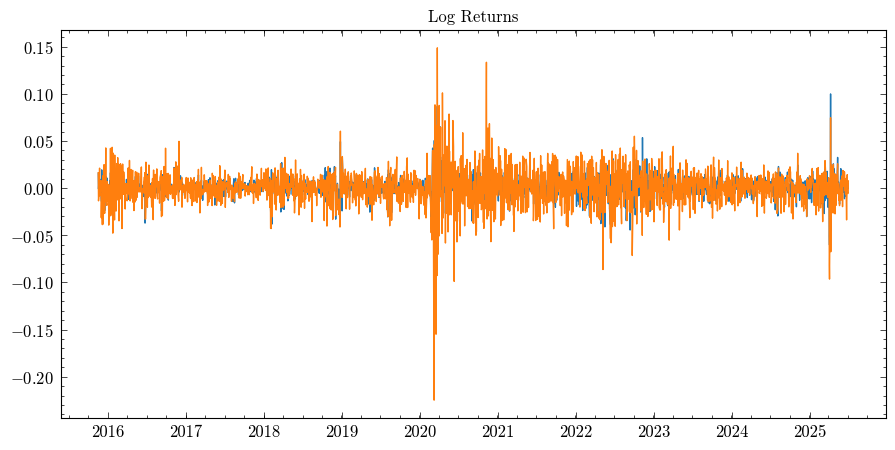

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Log Returns')
plt.plot(df['DATE'], df['SPY_r'])
plt.plot(df['DATE'], df['XLE_r'])

idiosyncratic volatility of XLE

In [ ]:
X = df[['SPY_r']]   #
y = df['XLE_r']     

model = LinearRegression()
model.fit(X, y)


df['XLE_idio'] = y - model.predict(X)

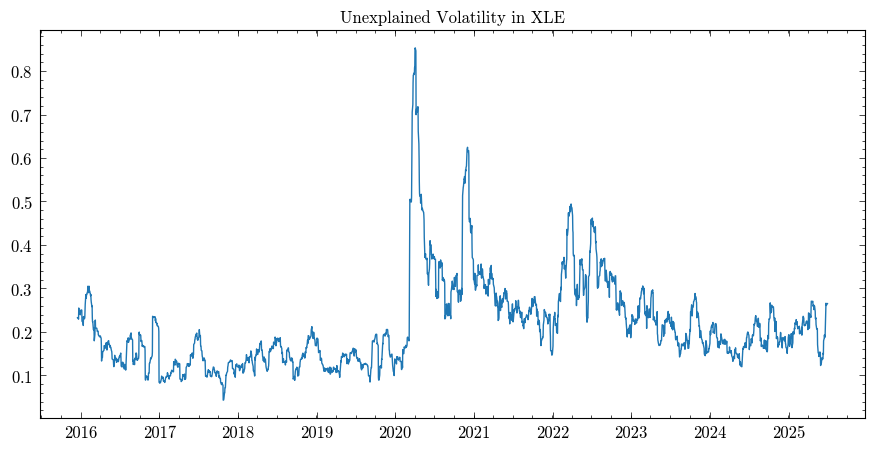

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['DATE'], realized_vol(df['XLE_idio']))

## GARCH

In [ ]:

stat, pval, fstat, fpval = het_arch(df['XLE_idio'].dropna())
print("ARCH p-value:", pval)

ARCH p-value: 5.57100375913047e-61


In [ ]:
adfuller(df['XLE_idio'])

(np.float64(-16.851708704207503),
 np.float64(1.1173469727034897e-29),
 6,
 2410,
 {'1%': np.float64(-3.4330662982661715),
  '5%': np.float64(-2.8627400264482548),
  '10%': np.float64(-2.5674088238838864)},
 np.float64(-13279.195797231429))

In [ ]:
y  = df['XLE_idio'] * 100
X = df[['CPIAUCSL', 'INDPRO', 'CNP16OV', 'FEDFUNDS', 'VIXCLS', 'UNRATE']]

In [ ]:
y

1       0.030694
2      -1.223879
3      -1.411756
4       0.872060
5       2.012836
          ...   
2413   -0.457429
2414    0.646976
2415   -1.004774
2416   -1.035307
2417    0.834849
Name: XLE_idio, Length: 2417, dtype: float64

In [ ]:
am = arch_model(
    y,
    mean='ARX',       # mean with exogenous regressors
    lags=1,           # 0 AR lags in the mean (you can set >0 if you want AR)
    x=X,              # exogenous variables in the mean
    vol='GARCH',      # GARCH volatility
    p=1, q=2,         # GARCH(1,1)
    dist='t'     # or 't' if you want fat tails
)


In [ ]:
res = am.fit(disp='off')

/tmp/ipykernel_43467/3265089574.py:1: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


In [ ]:
cond_vol = res.conditional_volatility
std_resid = res.std_resid


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AR-X - GARCH Model Results                             
====================================================================================
Dep. Variable:                     XLE_idio   R-squared:                  -72191.702
Mean Model:                            AR-X   Adj. R-squared:             -72401.564
Vol Model:                            GARCH   Log-Likelihood:               -17699.3
Distribution:      Standardized Student's t   AIC:                           35424.6
Method:                  Maximum Likelihood   BIC:                           35499.9
                                              No. Observations:                 2416
Date:                      Thu, Nov 13 2025   Df Residuals:                     2408
Time:                              20:14:21   Df Model:                            8
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         -23.3282   2156.422 -1.082e-02      0.991  [-4.250e+03,4.203e+03]
XLE_idio[1]   119.5443     10.549     11.332  9.065e-30     [ 98.869,1.402e+02]
CPIAUCSL      -31.2937      2.360    -13.258  4.039e-40       [-35.920,-26.668]
INDPRO       -320.9557     10.802    -29.712 5.314e-194 [-3.421e+02,-2.998e+02]
CNP16OV         0.1659  9.706e-03     17.087  1.850e-65       [  0.147,  0.185]
FEDFUNDS       66.5158      8.644      7.695  1.410e-14       [ 49.575, 83.457]
VIXCLS         21.8300      2.637      8.279  1.243e-16       [ 16.662, 26.998]
UNRATE       -644.0297     18.919    -34.041 5.589e-254 [-6.811e+02,-6.069e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega         22.4801     10.803      2.081  3.744e-02     [  1.307, 43.653]
alpha[1]   2.3452e-03  2.156e-04     10.878  1.473e-27 [1.923e-03,2.768e-03]
beta[1]        0.9975  5.657e-02     17.634  1.344e-69     [  0.887,  1.108]
beta[2]    9.6087e-07  5.675e-02  1.693e-05      1.000     [ -0.111,  0.111]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.1981      0.151     27.826 2.108e-170 [  3.902,  4.494]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Iteration limit reached.
See convergence_flag.

"""

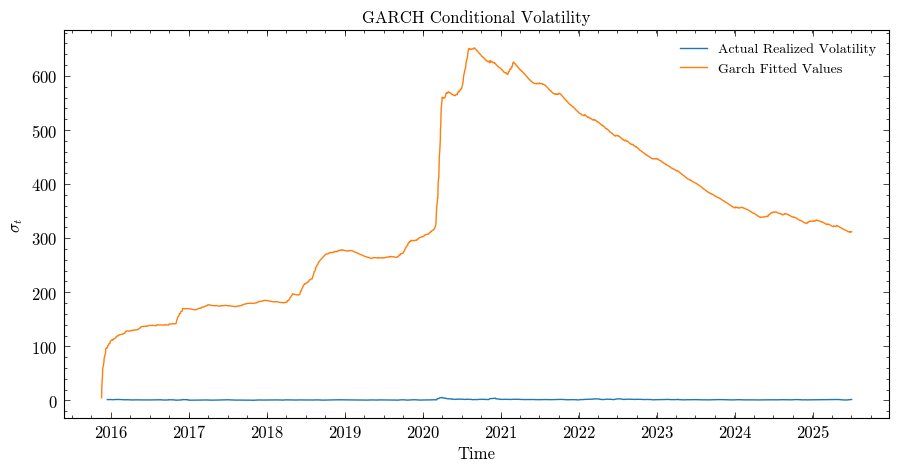

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], realized_vol(y), label="Actual Realized Volatility")
plt.plot(df['DATE'], res.conditional_volatility, label='Garch Fitted Values')
plt.title("GARCH Conditional Volatility")
plt.xlabel("Time")
plt.legend()
plt.ylabel(r"$\sigma_t$")  
# plt.yscale('log')
plt.show()

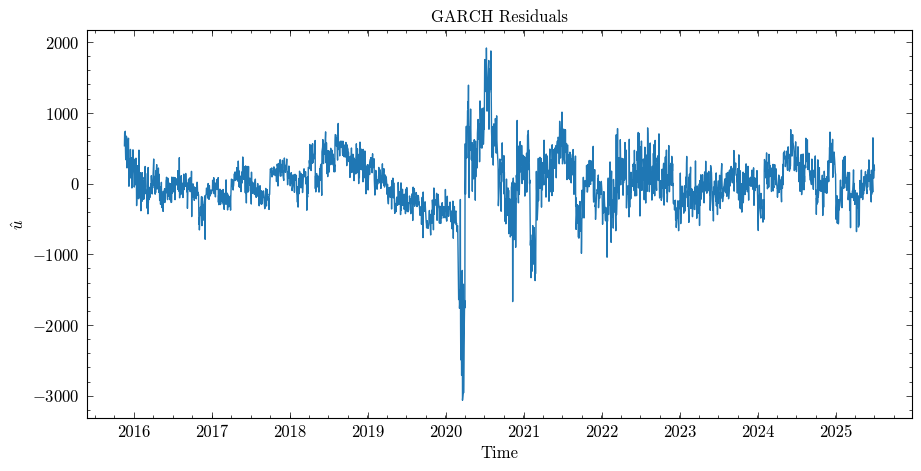

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.resid)
plt.title("GARCH Residuals")
plt.xlabel("Time")
plt.ylabel("$\hat{u}$")
plt.show()

TO DO:


- Exogenous features need to be stationary 
- In-sample rolling prediction 
- Convert to scikit learn model
- hyperparameter tuning